# Text Classifier

In [1]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns

import nlpaug.augmenter.word as naw

import matplotlib.pyplot as plt

%matplotlib inline

### Overview of dataset


Showing some insights from dataset.

In [2]:
# load dataset
df = pd.read_json('intents.json')
df = df['text_intent'].apply(pd.Series)

intents = list(set(df['intent']))
df['count_word'] = df['text'].apply(lambda x: len(x.split(' ')))

print('dataset:', len(df))
print('words (non unique):', df['count_word'].sum())
print('intents:', len(intents));
df.head(5)

dataset: 60
words (non unique): 375
intents: 6


,text,intent,count_word
0,I need to set up a meeting with John about Des...,schedule meeting,19
1,schedule a Deployment Issue meeting with Ben t...,schedule meeting,11
2,set up a meeting with amy and tom at noon,schedule meeting,10
3,I want to meet ben tomorrow morning,schedule meeting,7
4,please schedule a meeting for an hour at today...,schedule meeting,10


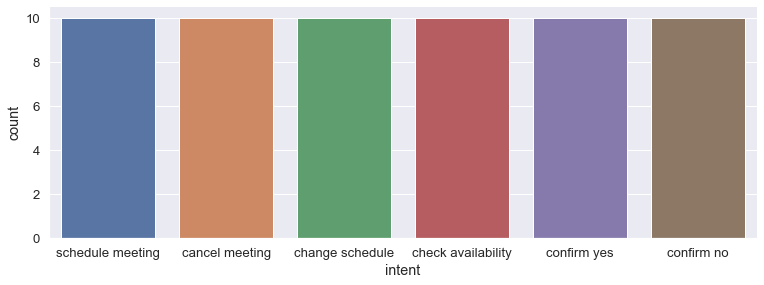

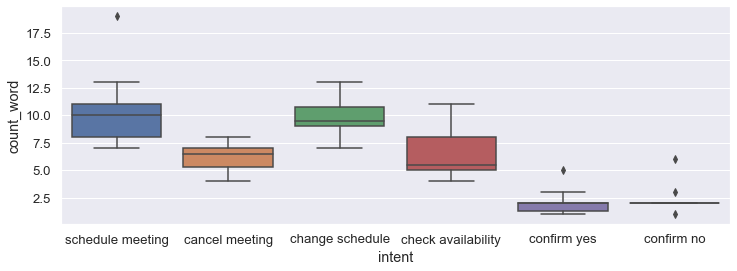

In [3]:
sns.set(font_scale=1.2)
g = sns.catplot(x='intent', kind='count', data=df);
g.fig.set_size_inches(12,4)

plt.figure(figsize=(12, 4))
g = sns.boxplot(data=df, x='intent', y='count_word')

### Dataset Preparation

Split dataset by 70:30. Add augmented text by swapping word randomly and substituting word by synonym, for each training data.

In [4]:
# split dataset
train_x, test_x, train_y, test_y = train_test_split(df['text'], df['intent'], stratify=df['intent'], random_state=0, test_size=0.30)

# text augmentation
augmented_texts = []
augmented_labels = []
augs = [
    naw.RandomWordAug(action='swap'), # swap word randomly,
    naw.WordNetAug() # substitute word by synonym
]
aug = naw.RandomWordAug(action='swap')
for i, row in train_x.iteritems():
    for aug in augs:
        if (df['count_word'].loc[i] > 1): # to avoid error
            augmented_text = aug.augment(row)
        else:
            augmented_text = row;
        augmented_texts.append(augmented_text)
        augmented_labels.append(train_y.loc[i])
    
s1 = pd.Series(augmented_texts)
s2 = pd.Series(augmented_labels)
train_x = train_x.append(s1, ignore_index=True)
train_y = train_y.append(s2, ignore_index=True)

print('# training data (after augmentation):', len(train_y))

# training data (after augmentation): 126


### Extracting Features + Model Training

Do performance tuning by using GridSearchCV on SVM model. CountVectorizer and TfidfTransformer are used to convert texts to count matrix and to normalize the count matrix.

In [5]:
# build pipeline
svm_clf = Pipeline([('vect', CountVectorizer()), # create feature vectors
                      ('tfidf', TfidfTransformer()), # normalized count matrix
                      ('clf-svm', svm.SVC()), # svm model
])

# performance tuning
parameters = {
              'vect__stop_words':('english', None),
              'tfidf__use_idf': (True, False),
              'clf-svm__kernel': ('linear', 'rbf'),
              'clf-svm__gamma': (0.0001, 0.001, 0.01, 0.1, 1),
              'clf-svm__C': (0.001, 0.01, 0.1, 1, 10, 100),
}
gs_clf = GridSearchCV(svm_clf, parameters, n_jobs=-1, cv=3, iid=True)
gs_clf = gs_clf.fit(train_x, train_y)
print('best score:', gs_clf.best_score_)
print('best params:', gs_clf.best_params_)

best score: 0.9920634920634921
best params: {'clf-svm__C': 1, 'clf-svm__gamma': 1, 'clf-svm__kernel': 'rbf', 'tfidf__use_idf': True, 'vect__stop_words': None}


### Model Evaluation

Predict the intent of the test data by using the trained model. Some metrics are used to show its quality.

In [6]:
predicted = gs_clf.predict(test_x)
print('Classification report:')
print(metrics.classification_report(test_y, predicted, target_names=intents))
print('Accuracy score:', metrics.accuracy_score(test_y, predicted))
print('\nConfusion matrix:')
print(metrics.confusion_matrix(test_y, predicted))

Classification report:
                    precision    recall  f1-score   support

        confirm no       0.67      0.67      0.67         3
   change schedule       0.60      1.00      0.75         3
check availability       1.00      1.00      1.00         3
       confirm yes       1.00      0.67      0.80         3
  schedule meeting       1.00      1.00      1.00         3
    cancel meeting       1.00      0.67      0.80         3

         micro avg       0.83      0.83      0.83        18
         macro avg       0.88      0.83      0.84        18
      weighted avg       0.88      0.83      0.84        18

Accuracy score: 0.8333333333333334

Confusion matrix:
[[2 1 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [1 0 0 2 0 0]
 [0 0 0 0 3 0]
 [0 1 0 0 0 2]]
